# 🌦 IoT Rain Data Examples — Citywise & Devicewise Analysis

This notebook demonstrates how to fetch, process, and visualize IoT rainfall data using the `fetch_iot()` API and helper functions.  
Each example focuses on a specific use case, showing how to handle pagination, aggregation (SUM or MAX), and comparison between cities and devices.

---

### ✅ **Examples Covered**

1. **Example 1:** Single device rain chart (MAX-based interactive plot)  
2. **Example 2:** Paginated Top 10 devices by MAX rain (Bochum, Oct 1–7, 2025)  
3. **Example 3:** City comparison (Bochum, Hagen, Lüdenscheid, Lübeck) — SUM of rainfall  
4. **Example 4:** Lübeck city — MAX rain per device (Sep 14–Oct 02, 2025)

---

### ⚙️ **Setup**

Before running the examples:
1. Ensure `fetch_iot()` and `to_df()` are defined.  
2. Verify that your `.env` and API credentials are loaded correctly.  
3. Run the setup and import cells first.


In [14]:
# Setup & imports
import os, sys
import pandas as pd
import matplotlib.pyplot as plt

# allow imports when running from /notebooks
sys.path.append("..")
sys.path.append(".")

# 1) load API client
from utils.iot_client import fetch_iot

# 2) load .env if present (kept for convenience)
from dotenv import load_dotenv
load_dotenv(os.path.join("..", "config", ".env")) or load_dotenv(os.path.join("config", ".env"))

print("Ready")

Ready


In [15]:
def to_df(rows):
    """
    Convert list[dict] -> DataFrame with light parsing.
    - parse minute_ts as UTC datetime
    - coerce rain_value to numeric
    - pre-sort by time if present
    """
    if not rows:
        return pd.DataFrame()
    df = pd.DataFrame(rows)
    if "minute_ts" in df.columns:
        df["minute_ts"] = pd.to_datetime(df["minute_ts"], utc=True, errors="coerce")
    if "rain_value" in df.columns:
        df["rain_value"] = pd.to_numeric(df["rain_value"], errors="coerce")
    if {"minute_ts", "rain_value"}.issubset(df.columns):
        df = df.sort_values("minute_ts")
    return df


def paginate_iot(*, city=None, from_ts=None, to_ts=None,
                 only_with_known_location=True, source="auto",
                 order="asc", page=1000, max_rows=50_000, verbose=True):
    """
    Pulls multiple pages from /iot using limit/offset until no more rows (or cap).
    Returns a single DataFrame.
    """
    all_rows, offset = [], 0
    while True:
        batch = fetch_iot(
            city=city,
            from_ts=from_ts, to_ts=to_ts,
            only_with_known_location=only_with_known_location,
            source=source,
            order=order,
            limit=page, offset=offset
        )
        if not batch:
            break
        all_rows.extend(batch)
        offset += page
        if verbose:
            print(f"Fetched {len(all_rows):,} rows...")
        if len(all_rows) >= max_rows:
            if verbose:
                print(f"Hit safety cap: {max_rows:,} rows.")
            break
    return to_df(all_rows)

## Example 1 — Single Device Rain Chart (MAX-based)

This interactive widget allows you to:
- Select a specific IoT rain sensor (device)
- Choose time buckets (1min, 5min, 15min, hourly)
- View bucketed **maximum rain values** or **running cumulative maximum**
- Filter the time window interactively

👉 **How to use:**
1. Run the cell to display interactive widgets.
2. Use the dropdowns to pick a device, time range, and aggregation mode.
3. The plot updates dynamically showing rain intensity patterns.


In [16]:

# Example 1 — Bochum (Oct 1–7), no pagination, only known locations, source=auto
rows1 = fetch_iot(
    city="Bochum",
    from_ts="2025-10-01T00:00:00Z",
    to_ts="2025-10-07T23:59:59Z",
    only_with_known_location=True,
    source="auto",
    order="asc",
    limit=1000,  # single call; no paging
    offset=0,
)
df1 = to_df(rows1)
print("df1 rows:", len(df1))
df1.head()


df1 rows: 1000


,dev_eui,minute_ts,rain_value,quality_flag,status,dev_name,longitude,latitude,city,sensor_site_name
0,0080E115004E327C,2025-10-01 00:00:00+00:00,NaN,9,NaN,None,7.213700,51.440100,Bochum,0080E115004E327C_KemnaderStraße_WeitmarMark
28,0080E115004E7C64,2025-10-01 00:00:00+00:00,0.0,1,NaN,None,7.241546,51.469333,Bochum,0080E115004E7C64_SportplatzPappelbusch_Altenbo...
27,0080E115004E6993,2025-10-01 00:00:00+00:00,0.0,1,NaN,None,7.152601,51.479614,Bochum,0080E115004E6993_LudwigSteilHaus_Wattenscheid
26,0080E115004E611F,2025-10-01 00:00:00+00:00,0.0,1,NaN,None,7.268676,51.491582,Bochum,0080E115004E611F_Kornharpen_KornhapenerStraße
25,0080E115004E6106,2025-10-01 00:00:00+00:00,0.0,1,NaN,None,7.142429,51.500400,Bochum,0080E115004E4707_Osterfeldstraße_FFGünnigfeld


In [17]:
# ---- Single-device rain chart (MAX-based) ----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import Dropdown, DatePicker, HBox, VBox, IntSlider, ToggleButtons, Button, Output
from IPython.display import display, clear_output

# ---- Pick a source dataframe --------------------------------------------------
_src = None
if "df" in globals():
    _src = df
elif "df1" in globals():
    _src = df1
elif "rows1" in globals() and "to_df" in globals():
    try:
        _src = to_df(rows1)
    except Exception:
        _src = None

assert _src is not None, (
    "No dataframe found. Run your fetch cell first (so that df or df1 exists), "
    "or define rows1 and to_df."
)

# ---- Clean & prepare ----------------------------------------------------------
df = _src.copy()
if "minute_ts" not in df.columns or "rain_value" not in df.columns or "dev_eui" not in df.columns:
    raise ValueError("Dataframe must include columns: minute_ts, rain_value, dev_eui (and ideally sensor_site_name).")

df["minute_ts"] = pd.to_datetime(df["minute_ts"], errors="coerce", utc=True)
df["rain_value"] = pd.to_numeric(df["rain_value"], errors="coerce")
df = df.dropna(subset=["minute_ts"]).sort_values("minute_ts")

if df.empty:
    display("No data returned.")
    raise SystemExit

# first known site name per device (nice labels)
if "sensor_site_name" in df.columns:
    dev_first_site = (
        df.sort_values("minute_ts")
          .groupby("dev_eui", as_index=True)["sensor_site_name"]
          .first()
    )
else:
    dev_first_site = df.groupby("dev_eui", as_index=True).size()
    dev_first_site[:] = None  # no site names available

def build_device_options():
    opts = []
    for row_eui, site in dev_first_site.items():
        label = f"{row_eui} — {site}" if isinstance(site, str) and site and site.lower() != "none" else str(row_eui)
        opts.append((label, row_eui))
    return opts

# ---- Widgets ------------------------------------------------------------------
device_dd   = Dropdown(description="Device", options=build_device_options())
agg_tb      = ToggleButtons(
    description="Bucket",
    options=[("per-minute","1min"), ("5-min max","5min"), ("15-min max","15min"), ("hourly max","60min")],
    value="1min"
)
series_tb   = ToggleButtons(
    description="Series",
    options=[("bucketed max","bucket"), ("running max","cum")],
    value="bucket"
)
roll_slider = IntSlider(description="Rolling (min)", min=0, max=60, step=5, value=0)
start_dp    = DatePicker(description="Start")
end_dp      = DatePicker(description="End")
find_btn    = Button(description="Jump to a rainy device", tooltip="Pick the device with highest max in this window")
out_plot    = Output()
out_table   = Output()
out_msg     = Output()

start_dp.value = df["minute_ts"].dt.tz_convert(None).min().date()
end_dp.value   = df["minute_ts"].dt.tz_convert(None).max().date()

# ---- Helpers ------------------------------------------------------------------
def current_window_df():
    sdate = pd.to_datetime(start_dp.value) if start_dp.value else None
    edate = pd.to_datetime(end_dp.value) if end_dp.value else None
    data = df
    if sdate is not None:
        data = data[data["minute_ts"] >= pd.Timestamp(sdate, tz="UTC")]
    if edate is not None:
        data = data[data["minute_ts"] <= (pd.Timestamp(edate, tz="UTC") + pd.Timedelta(days=1) - pd.Timedelta(seconds=1))]
    return data

def pick_best_device_for_window():
    win = current_window_df()
    if win.empty:
        return None
    m = (win.dropna(subset=["rain_value"])
           .groupby("dev_eui")["rain_value"].max()
           .sort_values(ascending=False))
    return m.index[0] if len(m) else None

# set initial device (best by MAX or most frequent)
best = pick_best_device_for_window()
valid_values = {v for _, v in device_dd.options}
if best in valid_values:
    device_dd.value = best
else:
    by_count = df["dev_eui"].value_counts()
    device_dd.value = by_count.index[0]

# ---- Plot + table -------------------------------------------------------------
def plot_and_table(*_):
    with out_plot: clear_output(wait=True)
    with out_table: clear_output(wait=True)
    with out_msg: clear_output(wait=True)

    sub_win = current_window_df()
    if sub_win.empty:
        with out_msg: print("No data in this date window.")
        return

    dev = device_dd.value
    sub = sub_win[sub_win["dev_eui"] == dev].copy()
    if sub.empty:
        with out_msg: print("No records for this device in the selected window.")
        return

    if not sub["rain_value"].notna().any():
        with out_msg: print("No numeric rain_value for this device in the selected window.")
        return

    sub = sub.set_index("minute_ts").sort_index()
    bucket = agg_tb.value
    series_mode = series_tb.value

    # Bucket by MAX
    y = sub["rain_value"].resample(bucket).max()

    # Optional rolling (minutes -> bucket windows)
    roll = int(roll_slider.value or 0)
    if roll > 0:
        bucket_minutes = max(int(pd.Timedelta(bucket).total_seconds() // 60), 1)
        window = max(int(round(roll / bucket_minutes)), 1)
        y = y.rolling(window=window, center=True, min_periods=1).mean()

    # Running max
    if series_mode == "cum":
        y = y.fillna(method="ffill")
        y = y.cummax()

    if (y.dropna().max() == 0):
        with out_msg: print("Selected device/window has only zeros. Try another device or a larger window.")

    with out_plot:
        plt.figure(figsize=(10, 4))
        plt.plot(y.index.tz_convert(None), y.values, label="rain_value")
        # make a nice title using the labeled option
        opt_label = next((k for k, v in device_dd.options if v == dev), str(dev))
        if series_mode == "bucket":
            ttl = f"Rain MAX ({bucket}) — {opt_label}"
            subtitle_val = np.nanmax(y.values)
            subtitle = f"Maximum rain in window: {subtitle_val:.2f} mm"
        else:
            ttl = f"Running MAX ({bucket}) — {opt_label}"
            subtitle_val = np.nanmax(y.values)
            subtitle = f"Final running max: {subtitle_val:.2f} mm"
        plt.title(ttl)
        plt.xlabel("timestamp"); plt.ylabel("rain_value (mm)")
        plt.grid(True, linestyle="--", alpha=0.3)
        plt.suptitle(subtitle, y=1.02, fontsize=10)
        plt.tight_layout()
        plt.show()

    # Table of top bucketed intervals by MAX
    if series_mode == "bucket":
        top = y.sort_values(ascending=False).dropna()
        top = top[top > 0].head(10).rename("rain_max_mm").to_frame()
        if not top.empty:
            top.index = top.index.tz_convert(None)
            with out_table:
                display(top)

def jump_to_rainy_device(_):
    best = pick_best_device_for_window()
    if best is not None and best != device_dd.value:
        device_dd.value = best
    else:
        with out_msg:
            print("No device with non-zero max found in this window.")

for w in (device_dd, agg_tb, series_tb, roll_slider, start_dp, end_dp):
    w.observe(plot_and_table, names="value")
find_btn.on_click(jump_to_rainy_device)

ui = VBox([
    HBox([device_dd, agg_tb, series_tb, roll_slider]),
    HBox([start_dp, end_dp, find_btn]),
    out_msg,
    out_plot,
    out_table
])

display(ui)
plot_and_table()


## Example 2 — Bochum (Oct 1–7) with pagination

**What is pagination (limit/offset)?**  
APIs often return data in pages instead of all at once. With *pagination*, we request a fixed `limit` (page size) and move through the dataset using `offset` (start index) until all rows are fetched. This avoids timeouts and memory spikes when the dataset is large.

**How we use it here**
- `PAGE` is our page size (e.g., 500 rows per request).
- `CAP` is a safety cap on total rows (to prevent runaway downloads).

**Highlights:**
- Uses a loop to safely fetch data in pages (limit/offset)
- Combines all pages into a single DataFrame
- Computes maximum rain per device
- Displays a horizontal bar chart (largest at top)

👉 **Run this cell** to automatically:
- Fetch Bochum data (Oct 1–7, 2025)
- Display a DataFrame preview
- Plot Top 10 devices by maximum rainfall



Rows in window: 20000


,dev_eui,minute_ts,rain_value,quality_flag,status,dev_name,longitude,latitude,city,sensor_site_name
0,0080E115004E327C,2025-10-01 00:00:00+00:00,NaN,9,NaN,None,7.213700,51.440100,Bochum,0080E115004E327C_KemnaderStraße_WeitmarMark
1,0080E115004E7C64,2025-10-01 00:00:00+00:00,0.0,1,NaN,None,7.241546,51.469333,Bochum,0080E115004E7C64_SportplatzPappelbusch_Altenbo...
2,0080E115004E6993,2025-10-01 00:00:00+00:00,0.0,1,NaN,None,7.152601,51.479614,Bochum,0080E115004E6993_LudwigSteilHaus_Wattenscheid
3,0080E115004E611F,2025-10-01 00:00:00+00:00,0.0,1,NaN,None,7.268676,51.491582,Bochum,0080E115004E611F_Kornharpen_KornhapenerStraße
4,0080E115004E6106,2025-10-01 00:00:00+00:00,0.0,1,NaN,None,7.142429,51.500400,Bochum,0080E115004E4707_Osterfeldstraße_FFGünnigfeld


,dev_eui,max_rain
15,0080E115004E53D3,2.0
3,0080E115004E4686,2.0
27,0080E115004E6993,2.0
18,0080E115004E5716,2.0
1,0080E115004E436D,0.0
26,0080E115004E611F,0.0
25,0080E115004E6106,0.0
24,0080E115004E60D1,0.0
23,0080E115004E606E,0.0
22,0080E115004E5BCB,0.0


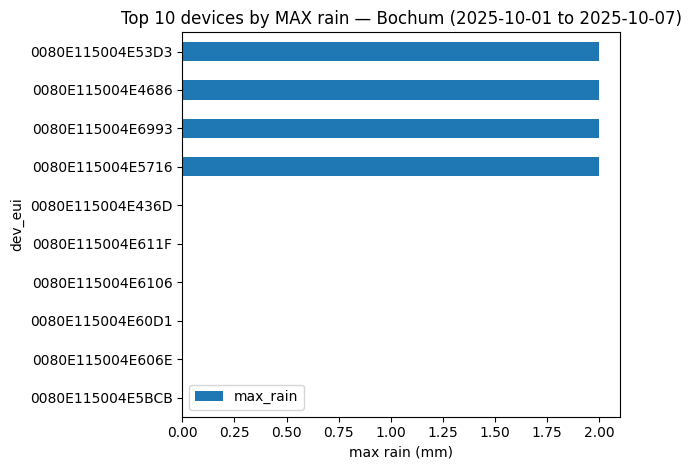

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- Window & params (adjust if you like) -------------------------------------
from_ts = "2025-10-01T00:00:00Z"
to_ts   = "2025-10-07T23:59:59Z"
CITY    = "Bochum"

PAGE = 500      # page size for each API call
CAP  = 20_000   # safety cap to avoid runaway downloads

def _have_fetch_funcs():
    return ("fetch_iot" in globals()) and ("to_df" in globals())

def paginate_iot(city, from_ts, to_ts, only_with_known_location=True,
                 source="auto", order="asc", page=500, max_rows=20_000):
    """Loop over the API in pages and return a single concatenated DataFrame."""
    assert _have_fetch_funcs(), "fetch_iot() and to_df() must exist to paginate from the API."
    frames = []
    offset = 0
    total  = 0
    while True:
        rows = fetch_iot(
            city=city,
            from_ts=from_ts,
            to_ts=to_ts,
            only_with_known_location=only_with_known_location,
            source=source,
            order=order,
            limit=page,
            offset=offset,
        )
        df_page = to_df(rows)
        if df_page.empty:
            break
        frames.append(df_page)
        got = len(df_page)
        total += got
        if total >= max_rows:
            break
        offset += page
    if frames:
        out = pd.concat(frames, ignore_index=True)
    else:
        out = pd.DataFrame()
    return out

# ---- Get the data (prefer pagination if possible) -----------------------------
if _have_fetch_funcs():
    df_paginated = paginate_iot(
        city=CITY,
        from_ts=from_ts, to_ts=to_ts,
        only_with_known_location=True,
        source="auto",
        order="asc",
        page=PAGE, max_rows=CAP
    )
else:
    # Fall back to any existing df from earlier cells (same columns expected)
    assert "df" in globals(), (
        "No fetch functions and no existing 'df' found. "
        "Either run the earlier fetch cell (defines fetch_iot/to_df), "
        "or create a dataframe named df with columns: dev_eui, rain_value, minute_ts."
    )
    # Filter df to the same time window so results are comparable
    _tmp = pd.to_datetime(df["minute_ts"], errors="coerce", utc=True)
    mask = (_tmp >= pd.Timestamp(from_ts)) & (_tmp <= pd.Timestamp(to_ts))
    df_paginated = df.loc[mask].copy()

print(f"Rows in window: {len(df_paginated)}")
display(df_paginated.head())

# ---- Top 10 devices by MAX rain_value (NOT sum) -------------------------------
if not df_paginated.empty:
    d = df_paginated.copy()
    # Ensure numeric
    d["rain_value"] = pd.to_numeric(d["rain_value"], errors="coerce")

    # Group by device and take MAX over the window
    top_devs = (
        d.groupby("dev_eui", as_index=False)["rain_value"]
         .max()  # MAX instead of SUM
         .rename(columns={"rain_value": "max_rain"})
         .sort_values("max_rain", ascending=False)
         .head(10)
    )

    display(top_devs)

    # Plot (horizontal bar; no custom colors)
    ax = top_devs.plot(
        x="dev_eui", y="max_rain",
        kind="barh",
        title=f"Top 10 devices by MAX rain — {CITY} ({from_ts[:10]} to {to_ts[:10]})"
    )
    plt.xlabel("max rain (mm)")     # adjust unit text if needed
    plt.ylabel("dev_eui")
    plt.gca().invert_yaxis()        # largest at top
    plt.tight_layout()
    plt.show()

    if (top_devs["max_rain"].fillna(0).max() == 0):
        print("Note: All devices have a maximum of 0 in this window.")
else:
    print("No data for this window.")


## Example 3 — Compare Rain MAX by City

**Goal:** Fetch multiple cities and compare the **maximum** recorded `rain_value` in the window.

**Logic:**
- Uses `paginate_city()` to safely fetch each city (paged with hard stops)
- Computes **MAX** of `rain_value` per city (peak intensity)
- Shows a simple bar chart of citywise maxima

👉 Run the cell to get a table and chart for the cities.



,city,rows,rain_max
0,Lüdenscheid,10000,3.0
1,Bochum,10000,2.0
2,Lübeck,10000,2.0
3,Hagen,10000,0.0


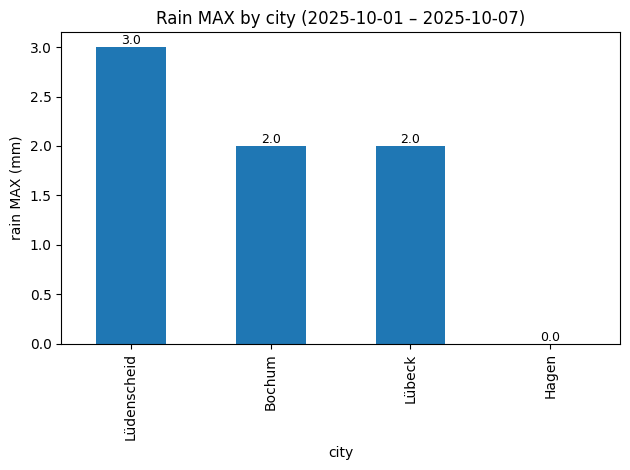

In [19]:
# ---- Example 3: City comparison by MAX rain (not SUM) ----
import warnings, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings(
    "ignore",
    message="The behavior of DataFrame concatenation with empty or all-NA entries is deprecated"
)

# Window
from_ts = "2025-10-01T00:00:00Z"
to_ts   = "2025-10-07T23:59:59Z"

# Pagination guards
PAGE, CAP, MAX_PAGES, VERBOSE = 250, 10_000, 40, False

def have_fetch_funcs():
    return ("fetch_iot" in globals()) and ("to_df" in globals())

def paginate_city(city, from_ts, to_ts,
                  only_with_known_location=True, source="auto", order="asc",
                  page=PAGE, cap=CAP, max_pages=MAX_PAGES, verbose=VERBOSE):
    """Safe paginator for a single city."""
    assert have_fetch_funcs(), "Need fetch_iot() and to_df() defined."
    frames, offset, total, last_sig = [], 0, 0, None
    for i in range(max_pages):
        rows = fetch_iot(
            city=city, from_ts=from_ts, to_ts=to_ts,
            only_with_known_location=only_with_known_location,
            source=source, order=order, limit=page, offset=offset,
        )
        d = to_df(rows)
        if d is None or d.empty: break
        sig = (tuple(d.iloc[0].values), tuple(d.iloc[-1].values))
        if sig == last_sig: break  # repeated page -> stop
        last_sig = sig
        frames.append(d); total += len(d)
        if len(d) < page or total >= cap: break
        offset += page
    frames = [f for f in frames if f is not None and not f.empty]
    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

cities = ["Bochum", "Hagen", "Lüdenscheid", "Lübeck"]
results = []

if have_fetch_funcs():
    for c in cities:
        df_c = paginate_city(c, from_ts, to_ts, only_with_known_location=True, source="auto", order="asc")
        if not df_c.empty and "rain_value" in df_c.columns:
            d = df_c.copy()
            d["rain_value"] = pd.to_numeric(d["rain_value"], errors="coerce")
            rain_max = float(d["rain_value"].max(skipna=True)) if len(d) else 0.0
            results.append({"city": c, "rows": int(len(d)), "rain_max": rain_max})
        else:
            results.append({"city": c, "rows": 0, "rain_max": 0.0})
else:
    # Fallback: use existing df already in memory
    assert "df" in globals(), "No fetch funcs and no 'df'. Provide a df with city/minute_ts/rain_value."
    d = df.copy()
    d["minute_ts"]  = pd.to_datetime(d["minute_ts"], errors="coerce", utc=True)
    d["rain_value"] = pd.to_numeric(d["rain_value"], errors="coerce")
    mask = (d["minute_ts"] >= pd.Timestamp(from_ts)) & (d["minute_ts"] <= pd.Timestamp(to_ts))
    d = d.loc[mask]
    for c, g in d.groupby("city", dropna=False):
        rain_max = float(g["rain_value"].max(skipna=True)) if "rain_value" in g.columns else 0.0
        results.append({"city": str(c), "rows": int(len(g)), "rain_max": rain_max})

df_cities = (pd.DataFrame(results)
             .sort_values("rain_max", ascending=False)
             .reset_index(drop=True))
display(df_cities)

if not df_cities.empty:
    ax = df_cities.plot(
        x="city", y="rain_max", kind="bar",
        title=f"Rain MAX by city ({from_ts[:10]} – {to_ts[:10]})",
        legend=False
    )
    ax.set_xlabel("city")
    ax.set_ylabel("rain MAX (mm)")
    for p, v in zip(ax.patches, df_cities["rain_max"]):
        ax.annotate(f"{v:.1f}", (p.get_x() + p.get_width()/2, p.get_height()),
                    ha="center", va="bottom", fontsize=9)
    plt.tight_layout(); plt.show()
else:
    print("No data for selected cities in the selected window.")



## Example 4 — Lübeck | MAX Rain per Device (Sep 14–Oct 02, 2025)

**Goal:** Simplified version focusing only on Lübeck city.

**Steps:**
1. Fetch Lübeck data between `2025-09-14` and `2025-10-02`
2. Use pagination with safety limits
3. Compute **MAX** rainfall per device
4. Display Top 10 devices with the highest recorded rainfall

👉 **Output:** A clean table and bar chart showing devices ranked by peak rainfall.


,dev_eui,max_rain
1,0080E115004E45ED,2.0
8,0080E115004E6120,2.0
9,0080E115004E7217,2.0
0,0080E115004E223A,1.0
2,0080E115004E4DB5,1.0
4,0080E115004E557C,1.0
5,0080E115004E5744,1.0
7,0080E115004E6040,1.0
10,0080E115004E72F2,1.0
11,0080E115004E761F,1.0


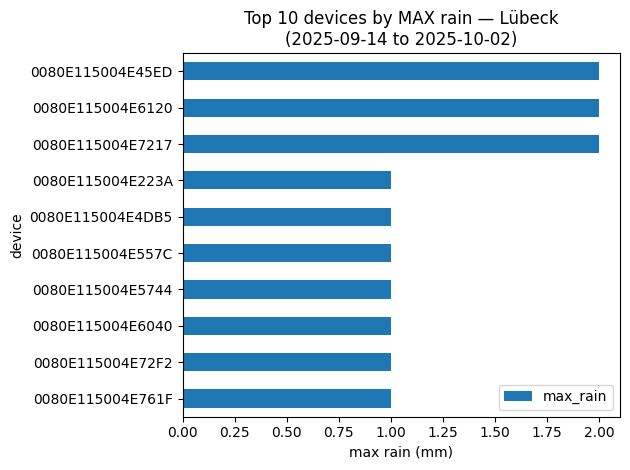

In [13]:
# ---- Lübeck | MAX rain per device (Sep 14–Oct 02, 2025) ----
import pandas as pd
import matplotlib.pyplot as plt

city = "Lübeck"
from_ts = "2025-09-14T00:00:00Z"
to_ts   = "2025-10-02T00:00:00Z"

PAGE = 200
CAP = 4000
MAX_PAGES = 8

def paginate_city(city):
    frames, offset, total = [], 0, 0
    last_sig = None
    for i in range(MAX_PAGES):
        rows = fetch_iot(
            city=city, from_ts=from_ts, to_ts=to_ts,
            only_with_known_location=True,
            source="auto", order="asc",
            limit=PAGE, offset=offset,
        )
        d = to_df(rows)
        if d is None or d.empty:
            break
        sig = (tuple(d.iloc[0].values), tuple(d.iloc[-1].values))
        if sig == last_sig:  # repeated page
            break
        last_sig = sig
        frames.append(d)
        total += len(d)
        if len(d) < PAGE or total >= CAP:
            break
        offset += PAGE
    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

# ---- Fetch + compute MAX ----
df = paginate_city(city)
if not df.empty and "rain_value" in df.columns:
    df["rain_value"] = pd.to_numeric(df["rain_value"], errors="coerce")
    top = (df.groupby("dev_eui", as_index=False)["rain_value"]
             .max()
             .rename(columns={"rain_value": "max_rain"})
             .sort_values("max_rain", ascending=False)
             .head(10))
    display(top)

    ax = top.plot(x="dev_eui", y="max_rain", kind="barh",
                  title=f"Top 10 devices by MAX rain — {city}\n({from_ts[:10]} to {to_ts[:10]})")
    plt.xlabel("max rain (mm)")
    plt.ylabel("device")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("No data for Lübeck in this window.")
